### Bajar dataset, instalar dependencias e importar librerias

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
!unzip Audio_Speech_Actors_01-24.zip -d ravdess

!sudo apt-get install sox
!pip install opensmile

import opensmile

from pathlib import Path
import tqdm
import glob

--2021-06-03 21:47:23--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip.1’

Audio_Speech_Actors 100%[===================>] 198.81M  18.3MB/s    in 12s     

2021-06-03 21:47:37 (16.2 MB/s) - ‘Audio_Speech_Actors_01-24.zip.1’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
replace ravdess/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Reading package lists... Done
Building dependency tree       
Reading state information... Done
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### Manejo de audio en colab

#### Escuchar audios

In [ ]:
from IPython.display import Audio

display(Audio('/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav'))

#### Leer audios como arrays de numpy

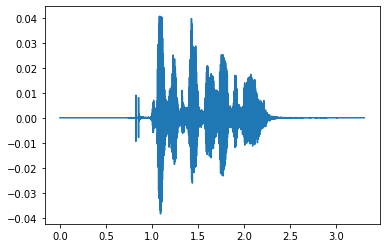

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

x, sr = sf.read('/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav')
display(Audio(x,rate=sr))
time = np.arange(0,len(x))/sr

plt.plot(time,x)

In [ ]:
sr

48000

### Recorrer estructuras de archivos y extraer metadata

In [ ]:
import glob
from pathlib import Path
import pandas as pd

ravdess = []
for file_path in glob.glob('/content/ravdess/Actor_*/*.wav'):
  filename = Path(file_path).stem
  filename_parts = filename.split('-')
  metadata = {'file_path': file_path,
              'modality': filename_parts[0],
              'vocal_channel': filename_parts[1],
              'emotion': filename_parts[2],
              'emotional_intensity': filename_parts[3],
              'statement': filename_parts[4],
              'repetition': filename_parts[5],
              'actor': filename_parts[6]}
  ravdess.append(metadata)

df_ravdess = pd.DataFrame(ravdess)

In [ ]:
df_ravdess.head()

,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor
0,/content/ravdess/Actor_06/03-01-03-02-01-01-06...,03,01,03,02,01,01,06
1,/content/ravdess/Actor_06/03-01-02-02-02-02-06...,03,01,02,02,02,02,06
2,/content/ravdess/Actor_06/03-01-06-02-02-02-06...,03,01,06,02,02,02,06
3,/content/ravdess/Actor_06/03-01-07-01-01-02-06...,03,01,07,01,01,02,06
4,/content/ravdess/Actor_06/03-01-02-01-01-02-06...,03,01,02,01,01,02,06


### Extracción de atributos del habla
#### Atributos de bajo nivel (LLD)

In [ ]:
filename = '/content/ravdess/Actor_01/03-01-03-02-01-01-01.wav'
display(Audio(filename))

smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

feats = smile.process_file(filename,channel=0)
feats = feats.reset_index()

In [ ]:
feats

,file,start,end,F0final_sma,voicingFinalUnclipped_sma,jitterLocal_sma,jitterDDP_sma,shimmerLocal_sma,logHNR_sma,audspec_lengthL1norm_sma,audspecRasta_lengthL1norm_sma,pcm_RMSenergy_sma,pcm_zcr_sma,audSpec_Rfilt_sma[0],audSpec_Rfilt_sma[1],audSpec_Rfilt_sma[2],audSpec_Rfilt_sma[3],audSpec_Rfilt_sma[4],audSpec_Rfilt_sma[5],audSpec_Rfilt_sma[6],audSpec_Rfilt_sma[7],audSpec_Rfilt_sma[8],audSpec_Rfilt_sma[9],audSpec_Rfilt_sma[10],audSpec_Rfilt_sma[11],audSpec_Rfilt_sma[12],audSpec_Rfilt_sma[13],audSpec_Rfilt_sma[14],audSpec_Rfilt_sma[15],audSpec_Rfilt_sma[16],audSpec_Rfilt_sma[17],audSpec_Rfilt_sma[18],audSpec_Rfilt_sma[19],audSpec_Rfilt_sma[20],audSpec_Rfilt_sma[21],audSpec_Rfilt_sma[22],audSpec_Rfilt_sma[23],audSpec_Rfilt_sma[24],audSpec_Rfilt_sma[25],pcm_fftMag_fband250-650_sma,pcm_fftMag_fband1000-4000_sma,pcm_fftMag_spectralRollOff25.0_sma,pcm_fftMag_spectralRollOff50.0_sma,pcm_fftMag_spectralRollOff75.0_sma,pcm_fftMag_spectralRollOff90.0_sma,pcm_fftMag_spectralFlux_sma,pcm_fftMag_spectralCentroid_sma,pcm_fftMag_spectralEntropy_sma,pcm_fftMag_spectralVariance_sma,pcm_fftMag_spectralSkewness_sma,pcm_fftMag_spectralKurtosis_sma,pcm_fftMag_spectralSlope_sma,pcm_fftMag_psySharpness_sma,pcm_fftMag_spectralHarmonicity_sma,mfcc_sma[1],mfcc_sma[2],mfcc_sma[3],mfcc_sma[4],mfcc_sma[5],mfcc_sma[6],mfcc_sma[7],mfcc_sma[8],mfcc_sma[9],mfcc_sma[10],mfcc_sma[11],mfcc_sma[12],mfcc_sma[13],mfcc_sma[14]
0,/content/ravdess/Actor_01/03-01-03-02-01-01-01...,0 days 00:00:00,0 days 00:00:00.060000,0.0,0.0,0.0,0.0,0.0,-100.0,0.002243,0.988341,0.000003,0.991551,0.129216,0.272048,0.419528,0.554447,0.669729,0.765896,0.847028,0.917829,0.982249,1.043099,1.102099,1.160070,1.217131,1.272837,1.326212,1.375581,1.418056,1.448481,1.457878,1.432704,1.358746,1.232340,1.069155,0.895928,0.734248,0.594331,2.459352e-11,2.189514e-10,6031.250,11734.375,17953.125,21703.125,0.000009,11886.155273,184.786148,48634096.0,0.014697,1.797559,-3.185704e-12,7.694283,4.799092e-10,-8.695683,1.894945,-0.297218,4.553033,6.464704,7.586986,-1.003380,-6.588314,-1.144949,5.597485,-1.030570,-5.133048,3.355277,0.806965
1,/content/ravdess/Actor_01/03-01-03-02-01-01-01...,0 days 00:00:00.010000,0 days 00:00:00.070000,0.0,0.0,0.0,0.0,0.0,-100.0,0.002683,0.988341,0.000003,0.990625,0.129216,0.272048,0.419528,0.554447,0.669729,0.765896,0.847028,0.917829,0.982249,1.043099,1.102099,1.160070,1.217131,1.272837,1.326212,1.375581,1.418056,1.448481,1.457878,1.432704,1.358746,1.232340,1.069155,0.895928,0.734248,0.594331,1.059875e-10,3.198359e-10,5531.250,10453.125,17234.375,21218.750,0.000025,11206.539062,143.723801,49877500.0,0.122200,1.838209,-5.260329e-11,7.277230,5.969199e-10,-6.333698,7.931332,-2.495125,0.613574,2.228783,14.002528,5.349797,-7.160648,-5.150008,2.284231,1.964986,-1.988852,-0.264813,0.031396
2,/content/ravdess/Actor_01/03-01-03-02-01-01-01...,0 days 00:00:00.020000,0 days 00:00:00.080000,0.0,0.0,0.0,0.0,0.0,-100.0,0.002797,0.988341,0.000003,0.990856,0.129216,0.272048,0.419528,0.554447,0.669729,0.765896,0.847028,0.917829,0.982249,1.043099,1.102099,1.160070,1.217131,1.272837,1.326212,1.375581,1.418056,1.448481,1.457878,1.432704,1.358746,1.232340,1.069155,0.895928,0.734248,0.594331,1.132170e-10,3.395497e-10,5515.625,10562.500,17203.125,21328.125,0.000042,11231.182617,127.747498,50302116.0,0.122731,1.850859,-5.202501e-11,7.287102,7.921450e-10,-5.756864,9.218508,-4.033250,0.928578,2.251007,12.575397,5.982955,-5.173528,-2.187850,1.660045,2.872938,-1.759217,-3.240742,0.423410
3,/content/ravdess/Actor_01/03-01-03-02-01-01-01...,0 days 00:00:00.030000,0 days 00:00:00.090000,0.0,0.0,0.0,0.0,0.0,-100.0,0.002654,0.988341,0.000003,0.990972,0.129216,0.272048,0.419528,0.554447,0.669729,0.765896,0.847028,0.917829,0.982249,1.043099,1.102099,1.160070,1.217131,1.272837,1.326212,1.375581,1.418056,1.448481,1.457878,1.432704,1.358746,1.232340,1.069155,0.895928,0.734248,0.594331,1.046262e-10,3.084369e-10,5671.875,10796.875,17281.250,21406.250,0.000041,11383.545898,143.479416,49766900.0,0.106344,1.858555,-4.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

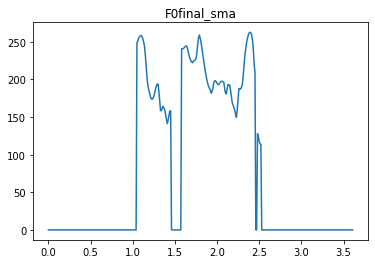

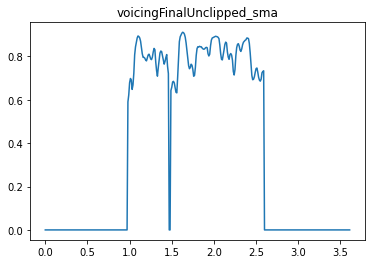

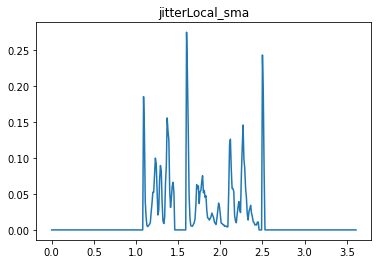

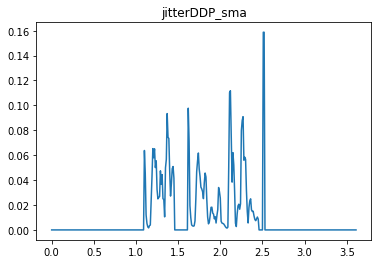

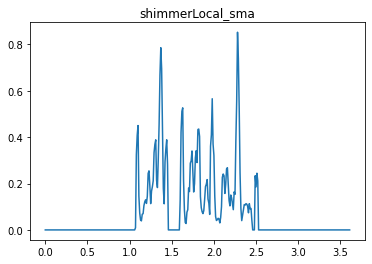

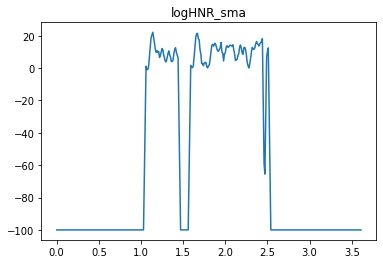

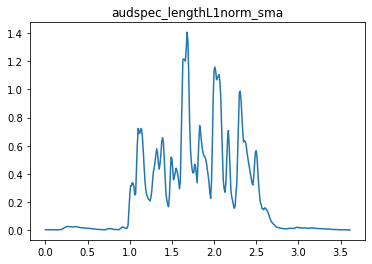

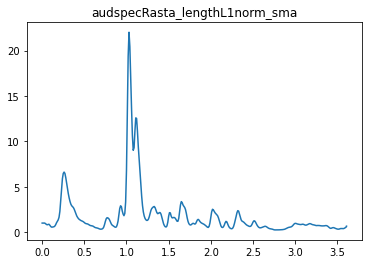

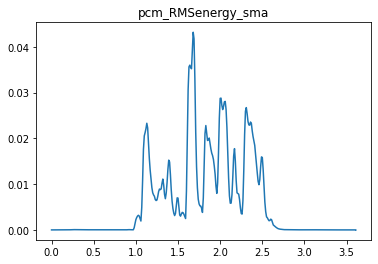

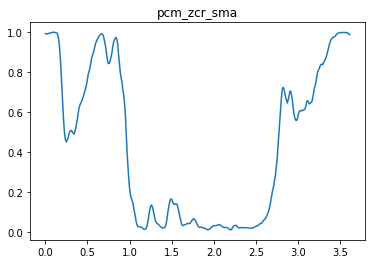

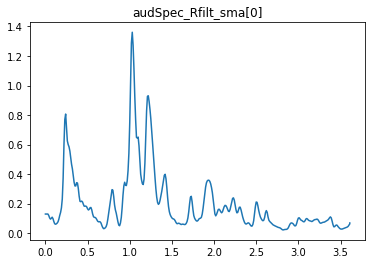

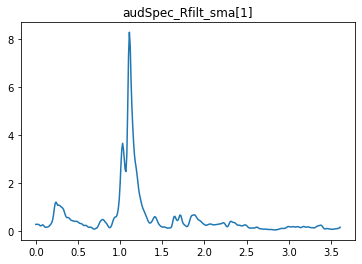

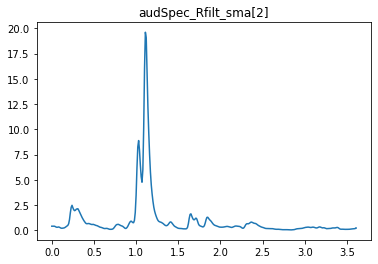

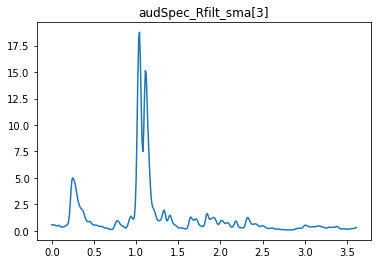

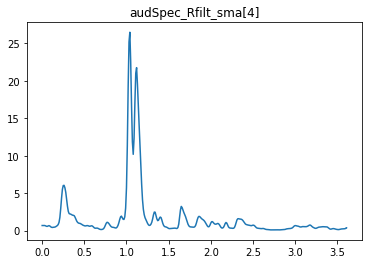

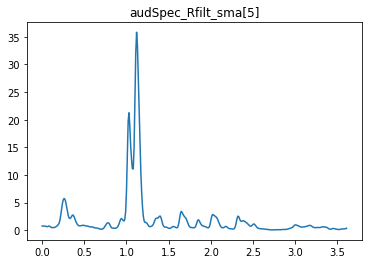

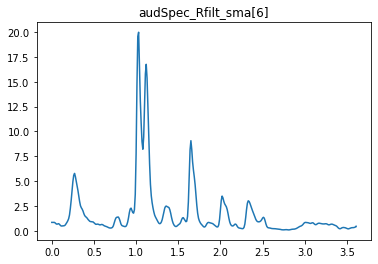

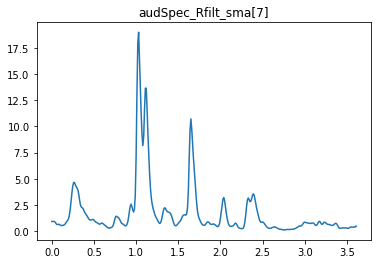

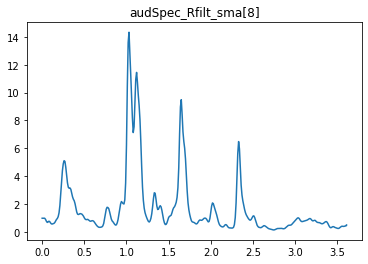

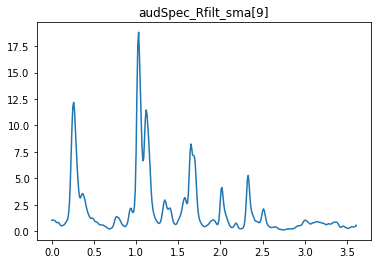

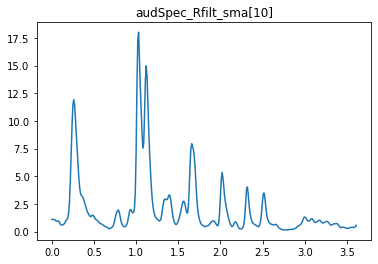

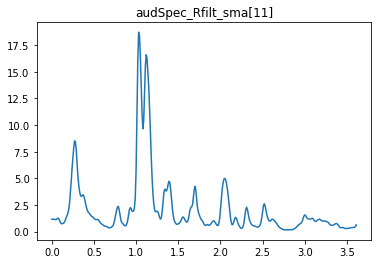

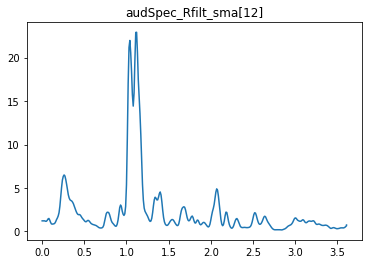

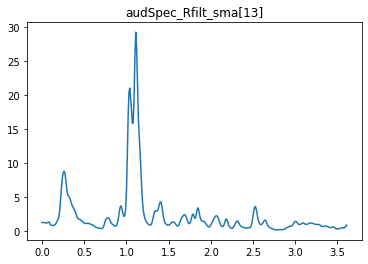

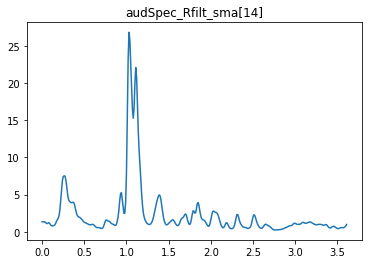

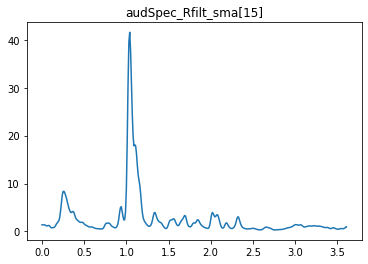

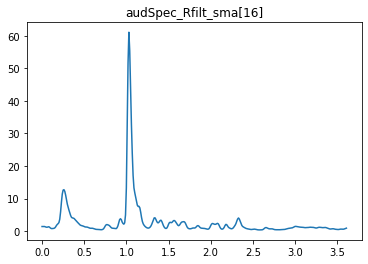

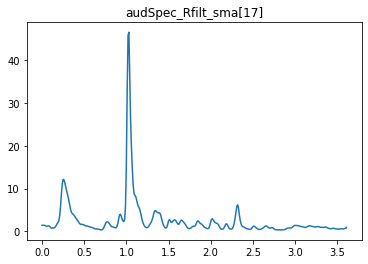

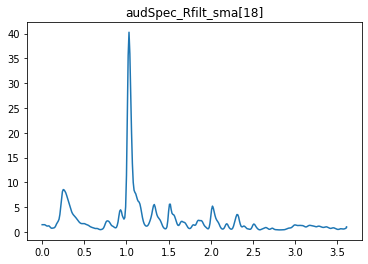

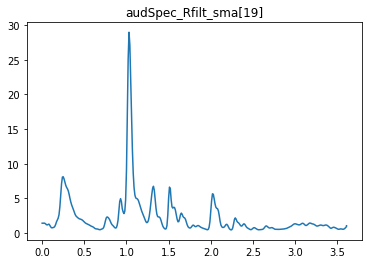

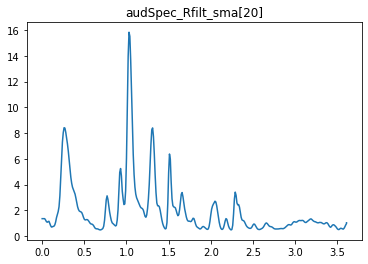

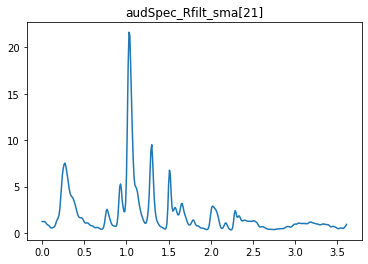

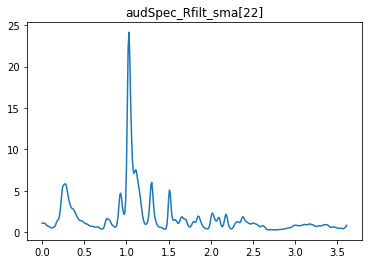

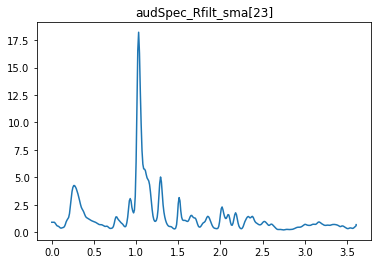

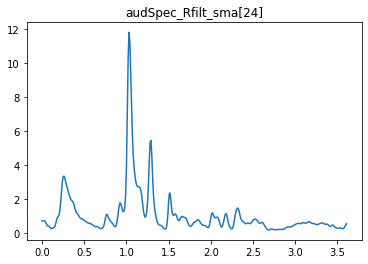

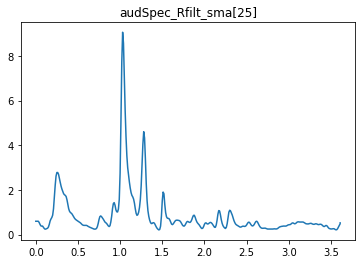

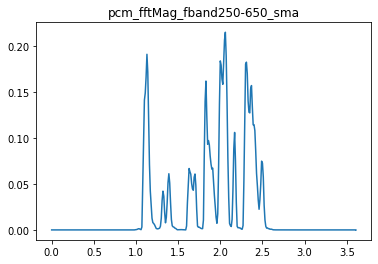

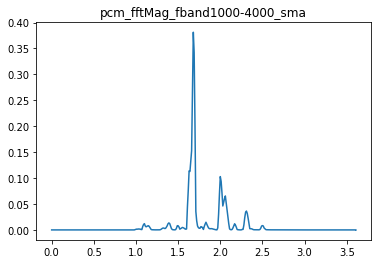

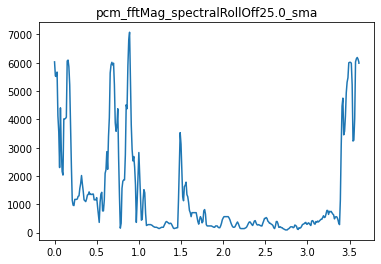

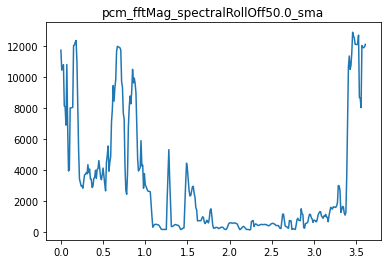

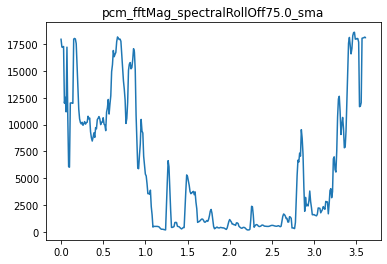

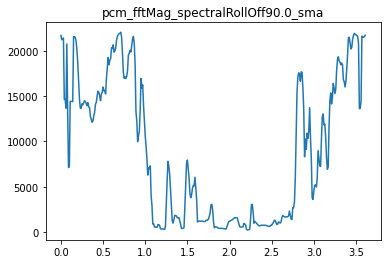

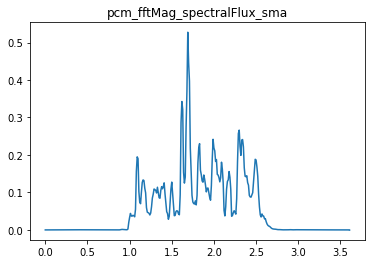

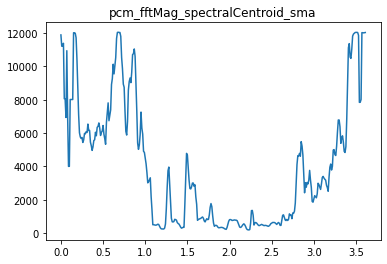

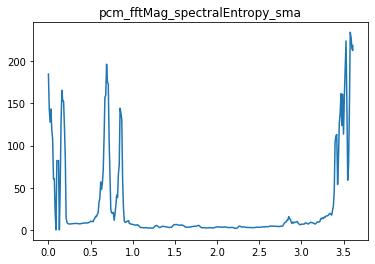

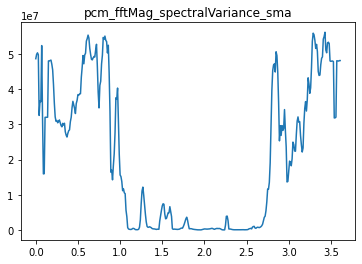

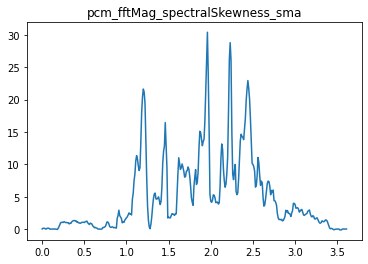

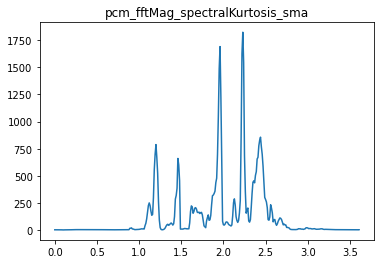

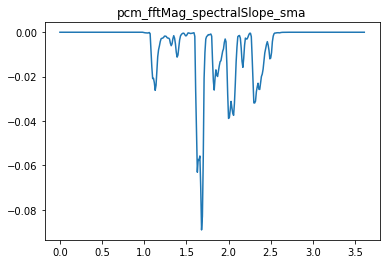

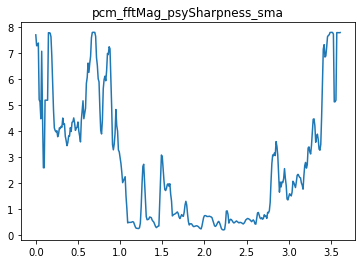

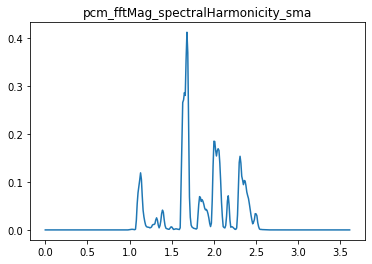

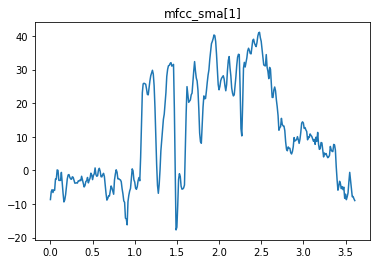

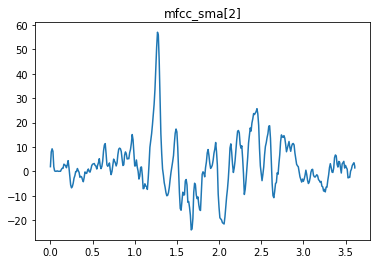

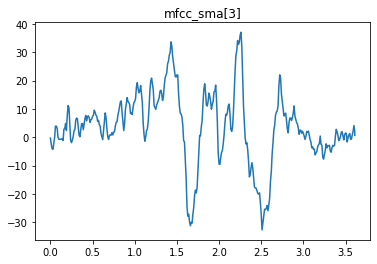

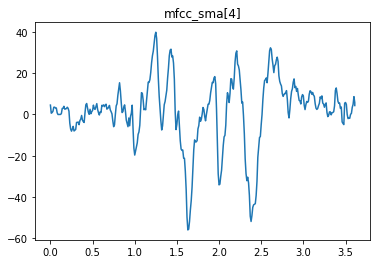

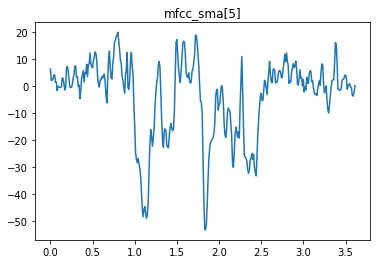

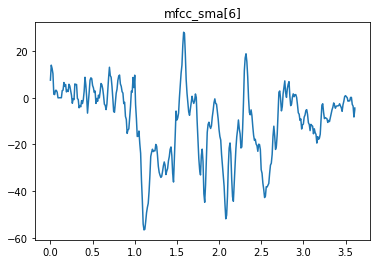

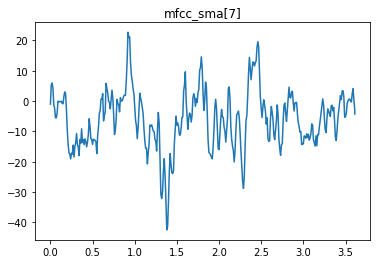

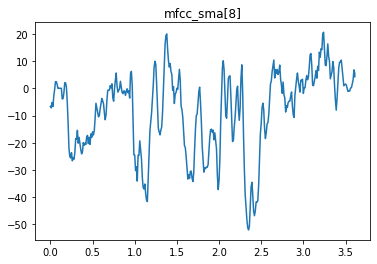

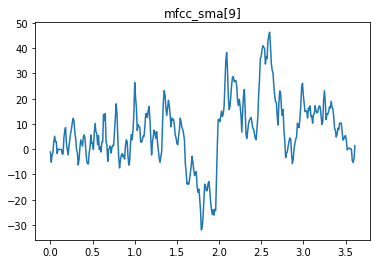

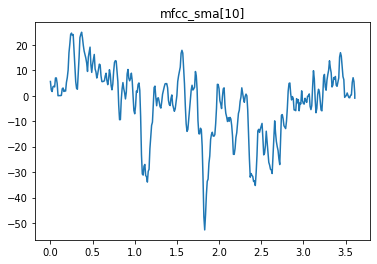

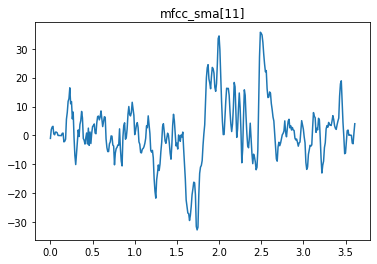

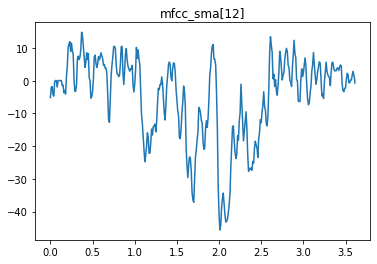

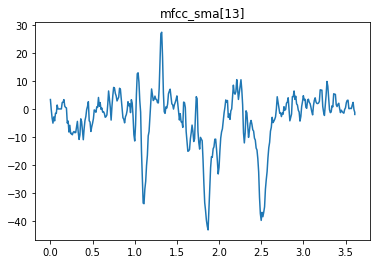

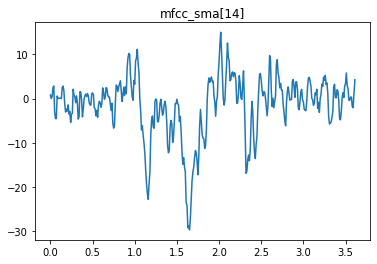

In [ ]:
feats_cols = [col for col in feats.columns if col not in ['file','start','end']]
for col in feats_cols:
  plt.figure()
  plt.plot(feats.start.dt.total_seconds(),feats[col].values)
  plt.title(col)

#### Atributos de alto nivel (Functionals)

Se calculan a partir de los atributos de bajo nivel, calculando estadísticas que resuman las secuencias. Los modelos que vimos no modelan secuencias!, por ende, es necesario disponer de atributos que consistan de vectores fijos.

In [ ]:
smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
)

feats = smile.process_file(filename,channel=0)
feats = feats.reset_index()

In [ ]:
feats

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,...,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,/content/ravdess/Actor_01/03-01-03-02-01-01-01...,0 days,0 days 00:00:03.670333333,34.288193,0.096482,31.886692,33.992844,37.641438,5.754745,49.435265,25.819061,6.213152,27.50914,0.239502,1.320631,0.007803,0.023869,0.478842,0.471039,8.752121,4.842955,5.101761,2.534611,0.116249,1.516747,10.600124,1.441306,2.494573,4.257956,3.481335,3.596514,1.586078,10.282188,0.033865,0.906137,1.599867,0.626025,4.880901,0.901426,5.427282,...,860.869812,0.269879,-132.281326,-0.666653,2536.722168,0.138149,648.948242,0.435052,-134.638947,-0.632414,-11.601998,-0.644414,20.146824,0.409601,0.119809,0.269067,-0.013933,-0.910844,0.291861,0.62945,24.773289,0.444271,2.308894,6.694097,4.535628,3.836314,-2.737312,-8.644202,0.281788,8.279852,0.07089,0.012436,0.015226,2.73224,0.831025,0.436667,0.339837,0.74,0.445646,-39.13559


#### Generar ruidos

In [ ]:
noise = np.random.uniform(low=-1,high=1,size=(len(x),))
display(Audio(noise,rate=sr))
display(Audio(0.01*noise+x,rate=sr))

In [ ]:
0.0001 0.001

In [ ]:
import librosa

20*np.log10(np.quantile(librosa.feature.rms(x),0.9)/np.quantile(librosa.feature.rms(0.005*noise),0.9))

7.544956518741227